In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%%time
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'

tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]
varlist = ['Z3','Q','PS','PBLH','T','U','V','U10','PSL','OMEGA']+tracer_3d

diri = os.path.join(dataroot,'orcas','cesm_flight_data')
model_files = [os.path.join(diri,'.'.join([case,os.path.basename(f)])) 
              for f in gv.flight_file]

obs = xr.open_mfdataset(gv.flight_file)
mdl = xr.open_mfdataset(model_files)

obs['GGALT'] = obs.GGALT * 1e-3
obs.GGALT.attrs['units'] = 'km'

mdl['GGALT'] = obs.GGALT.copy()
mdl['GGLAT'] = obs.GGLAT.copy()
mdl['GGLON'] = obs.GGLON.copy()
mdl.info()

xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	datetime64[ns] time(time) ;
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		C

### Apply a mask to avoid land and points north of latitude boundary

mask points over land

In [3]:
lat_rgn = [-90.,-44]
lon_rgn = [-180.,180.]

named_points = {
    'SCCI' : [-53.01062,-70.85168,42],
    'SCAR' : [-18.3483,-70.3386, 167],
    'SCTE' : [-41.438611, -73.0939, 294],
    'SCVD' : [-39.649722,-73.086111,59]}

airport_lon = np.array([v[1] for v in named_points.values()])
airport_lat = np.array([v[0] for v in named_points.values()])

def region_quality_mask(x,y,z):
    from earth_geometry import points_in_range

    #-- land_mask = within 10km of airport and below 4 km
    land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )

    #-- region_mask 
    region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )

    return ( land_mask & region_mask )


earth_geometry.py:57: RuntimeWarning: invalid value encountered in less_equal
  mask = np.array((haversine(clon,clat,plon.ravel(),plat.ravel()) <= range_km))
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


Text(0,0.5,u'Altitude')

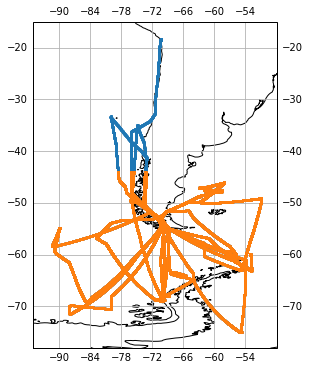

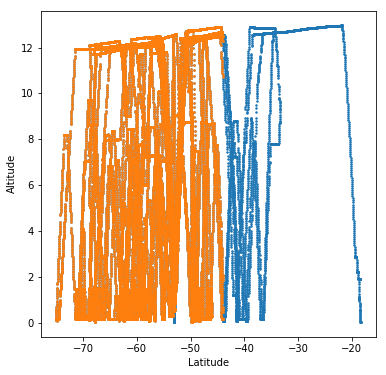

In [4]:
fig = plt.figure(figsize=(6,6))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=crs_latlon)
ax.set_extent([-95,-48,-78,-15],crs=crs_latlon)
ax.coastlines('50m')
ax.gridlines(draw_labels=True)

ax.plot(mdl.GGLON,mdl.GGLAT,'.',markersize=3,transform=crs_latlon)
ds = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
ax.plot(ds.GGLON,ds.GGLAT,'.',markersize=3,transform=crs_latlon)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(mdl.GGLAT,mdl.GGALT,'.',markersize=3)
ax.plot(ds.GGLAT,ds.GGALT,'.',markersize=3)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude')

In [5]:
mdl = mdl.where(region_quality_mask(mdl.GGLON.values,mdl.GGLAT.values,mdl.GGALT.values))
obs = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
